In [1]:
%ls ../etc

control_teste_motor_direito_frente.csv   motor_esquerdo_2.csv
control_teste_motor_direito_tras.csv     motor_esquerdo_3.csv
control_teste_motor_esquerdo_frente.csv  motor_esquerdo_4.csv
control_teste_motor_esquerdo_tras.csv    motor_esquerdo_5.csv
motor_direito_0.csv                      motor_esquerdo_6.csv
motor_direito_1.csv                      motor_esquerdo_7.csv
motor_direito_2.csv                      motor_esquerdo_8.csv
motor_direito_3.csv                      motor_esquerdo_9.csv
motor_direito_4.csv                      motor_esquerdo.csv
motor_direito_5.csv                      _pyplotter.py
motor_direito_6.csv                      teste_motor_direito.csv
motor_direito_7.csv                      teste_motor_direito_frente.csv
motor_direito_8.csv                      teste_motor_direito_tras.csv
motor_direito_9.csv                      teste_motor_esquerdo.csv
motor_direito.csv                        teste_motor_esquerdo_frente.csv
motor_esquerdo_0.csv                     te

In [2]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import scipy
print('Matplotlib Version:{}'.format(matplotlib.__version__))
print('Numpy Version:{}'.format(np.__version__))
print('Pandas Version:{}'.format(pd.__version__))
print('Scipy Version:{}'.format(scipy.__version__))

Matplotlib Version:3.3.2
Numpy Version:1.19.2
Pandas Version:1.0.5
Scipy Version:1.5.0


In [4]:
data = np.array([
[1905.72803 , 1.00000],
[1821.21313 , 0.95750],
[1729.47572 , 0.91500],
[1653.03481 , 0.87250],
[1616.04560 , 0.83000],
[1580.67555 , 0.78750],
[1480.13788 , 0.74500],
[1376.98560 , 0.70250],
[1230.54941 , 0.66000],
[1111.08493 , 0.61750],
[989.78975 , 0.57500],
[877.41730 , 0.53250],
[785.88934 , 0.49000],
[678.45646 , 0.44750],
[604.61752 , 0.40500],
[507.48609 , 0.36250],
[371.34665 , 0.32000],
[210.34399 , 0.27750],
[90.20955 , 0.23500],
[0.00000 , 0.19250]])
x = data[:,0]
y = data[:,1]

[0.00041236 0.17109272] [[ 8.79278993e-11 -9.06558066e-08]
 [-9.06558066e-08  1.24237197e-04]]


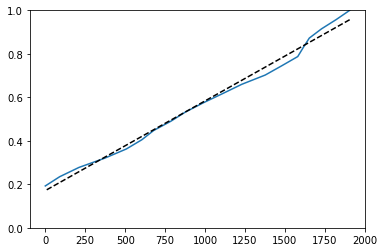

In [5]:
def line(x, a,b):
    return x*a + b

pop, pcov = curve_fit(line, x, y, bounds=([0, 0], [np.inf, 1.0]))
print(pop,pcov)

plt.plot(x,y, label='data')
plt.plot(x,line(x,pop[0], pop[1]), '--k')
plt.ylim([0,1])
plt.show()

In [6]:
1.0/pop[0]

2425.0422633974144

In [7]:
# motor_d = pd.read_csv('../etc/motor_direito_0.csv')
# motor_e = pd.read_csv('../etc/motor_esquerdo_0.csv')
# motor_d = pd.read_csv('../etc/teste_motor_direito_frente.csv')
# motor_e = pd.read_csv('../etc/teste_motor_esquerdo_frente.csv')
motor_d = pd.read_csv('../etc/control_teste_motor_direito_frente.csv')
motor_e = pd.read_csv('../etc/control_teste_motor_esquerdo_frente.csv')
# motor_d = pd.read_csv('../etc/control_teste_motor_direito_tras.csv')
# motor_e = pd.read_csv('../etc/control_teste_motor_esquerdo_tras.csv')

In [8]:
motor_e.head()

,MOTOR,CONTROLLER,SET_POINT,OMEGA_MAX,K,TAU,FORWARD_KP,BACK_KP,FORWARD_ANG_COEF,FORWARD_LIN_COEF,BACK_ANG_COEF,BACK_LIN_COEF,TIME,OMEGA_RAW,OMEGA_FILTERED,OMEGA_PREDICTED,K_GAIN,PREDIC_ERR,MEASURE_ERR
0,0,1,1,1814.2,2445.26,0.094737,0.000036,0.000007,0.000377,0.094546,0.000366,-0.087437,0.000005,0.0,0.0,0.0,0.0,0.0,0
1,0,1,1,1814.2,2445.26,0.094737,0.000036,0.000007,0.000377,0.094546,0.000366,-0.087437,0.004052,0.0,0.0,0.0,0.0,0.0,0
2,0,1,1,1814.2,2445.26,0.094737,0.000036,0.000007,0.000377,0.094546,0.000366,-0.087437,0.009050,0.0,0.0,0.0,0.0,0.0,0
3,0,1,1,1814.2,2445.26,0.094737,0.000036,0.000007,0.000377,0.094546,0.000366,-0.087437,0.014050,0.0,0.0,0.0,0.0,0.0,0
4,0,1,1,1814.2,2445.26,0.094737,0.000036,0.000007,0.000377,0.094546,0.000366,-0.087437,0.019050,0.0,0.0,0.0,0.0,0.0,0


In [9]:
data = np.array([[0.00001, 0.00000],
[0.00419, 0.00000],
[0.00919, 1.39470],
[0.01418, 1.40516],
[0.01919, 325.16614],
[0.02419, 325.16614],
[0.02918, 414.23954],
[0.03419, 709.00308],
[0.03918, 841.12253],
[0.04419, 953.29773]])

x = data[:,0]
y = data[:,1]

In [10]:
#   double Sxx = 0.0;
#   double Sxy = 0.0;
#   double y;

#   for(uint32_t i = 0; i < n; i++)
#   {
#     if( (abs(w[i]) > 0.2*abs(Wss)) && (abs(w[i]) < 0.8*abs(Wss)) )
#     {
#       y = -log(1.0 - w[i]/Wss + 0.001);
#       Sxy+= t[i]*y;
#       Sxx+= t[i]*t[i];
#     }
#   }

#   return Sxx/Sxy;
def _calcTau(t,w, wss):
    Sxx = 0.0
    Sxy = 0.0
    y = 0.0
    for i in range(len(t)):
        if (abs(w[i]) > 0.2*abs(wss)) and (abs(w[i]) < 0.8*abs(wss)):
            y = -np.log(1.0 - w[i]/wss);
            Sxy+= t[i]*y;
            Sxx+= t[i]*t[i];
    return Sxx/Sxy

In [11]:
# _calcTau(x,y,)

In [12]:
motor_e['OMEGA_MAX'][0]*1.1

1995.6200000000001

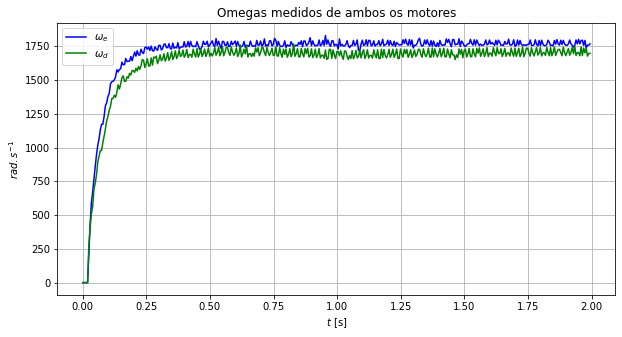

In [13]:
t = motor_e['TIME']
we= motor_e['OMEGA_RAW']
wd= motor_d['OMEGA_RAW']

plt.figure(figsize=(10,5))
plt.title('Omegas medidos de ambos os motores')
plt.plot(t, we, '-b', label=r'$\omega_e$')
plt.plot(t, wd, '-g', label=r'$\omega_d$')

plt.ylabel(r'$rad.s^{-1}$')
plt.xlabel(r'$t$ [s]')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
def func(t,K,Tm):
    return K*(1.0 - np.exp(-t/Tm))

In [15]:
popt_e, pcov_e = curve_fit(func, t, we, bounds=([-10000., 0.01], [10000., 1000]))
popt_d, pcov_d = curve_fit(func, t, wd, bounds=([-10000., 0.01], [10000., 1000]))

In [16]:
print('popt_e = {}\npcov_e:\n{}'.format(popt_e, pcov_e))
print('popt_d = {}\npcov_d:\n{}'.format(popt_d, pcov_d))

popt_e = [1.77176140e+03 7.17561862e-02]
pcov_e:
[[4.58308716e+00 5.56839251e-04]
 [5.56839251e-04 7.91544652e-07]]
popt_d = [1.70281405e+03 8.15424746e-02]
pcov_d:
[[4.35256081e+00 6.25288079e-04]
 [6.25288079e-04 9.17648078e-07]]


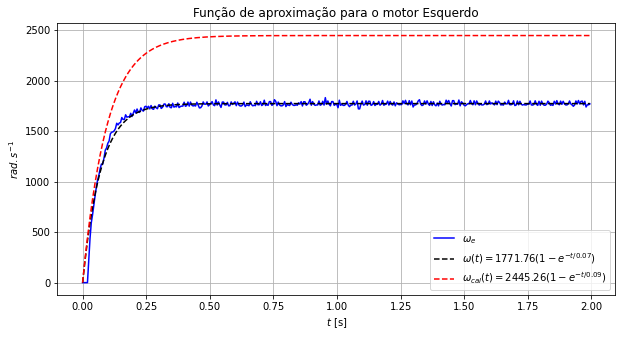

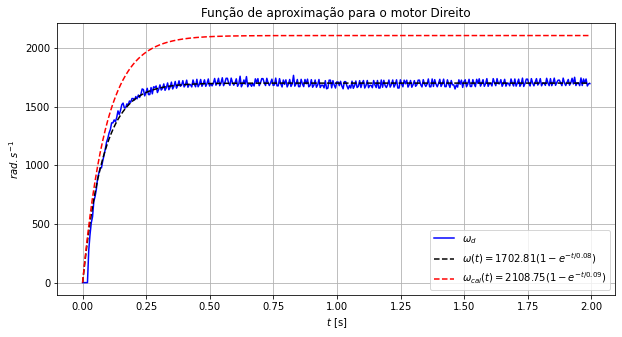

In [17]:
Ke = popt_e[0]
Tme= popt_e[1]

Kd = popt_d[0]
Tmd= popt_d[1]

plt.figure(num=1,figsize=(10,5))
plt.title('Função de aproximação para o motor Esquerdo')
plt.plot(t, we, '-b', label=r'$\omega_e$')
plt.plot(t, func(t,Ke,Tme), '--k', label=r'$\omega(t) = %.2f\left( 1 - e^{-t/%.2f}\right)$'%(Ke,Tme))
plt.plot(t, func(t,motor_e['K'][0],motor_e['TAU'][0]), '--r', label=r'$\omega_{cal}(t) = %.2f\left( 1 - e^{-t/%.2f}\right)$'%(motor_e['K'][0],motor_e['TAU'][0]))

plt.ylabel(r'$rad.s^{-1}$')
plt.xlabel(r'$t$ [s]')
plt.grid(True)
plt.legend()


plt.figure(num=2,figsize=(10,5))
plt.title('Função de aproximação para o motor Direito')
plt.plot(t, wd, '-b', label=r'$\omega_d$')
plt.plot(t, func(t,Kd,Tmd), '--k', label=r'$\omega(t) = %.2f\left( 1 - e^{-t/%.2f}\right)$'%(Kd,Tmd))
plt.plot(t, func(t,motor_d['K'][0],motor_d['TAU'][0]), '--r', label=r'$\omega_{cal}(t) = %.2f\left( 1 - e^{-t/%.2f}\right)$'%(motor_d['K'][0],motor_d['TAU'][0]))

plt.ylabel(r'$rad.s^{-1}$')
plt.xlabel(r'$t$ [s]')
plt.grid(True)
plt.legend()

plt.show()

In [18]:
Ke

1771.7614043318265

## Mínimos quadrados recursivo para estimar o ganho da planta (K)

Variável a ser estimada:
\begin{equation}
    x_k = K
\end{equation}

Váriavel medida:
\begin{equation}
    y_k = \omega_k = K(1 - e^{-\frac{t}{Tm}})
\end{equation}

Modelando como:

\begin{equation}
    y_k = H_k.x_k + v_k; v_k \sim N(0,R_k)
\end{equation}

Portando $H_k$ é:

\begin{equation}
    H_k = 1 - e^{-\frac{t}{Tm}}
\end{equation}

Atualizando a estimativa para $x_k$:
\begin{align}
    K_k &= P_{k-1}H^T_k \left( H_k P_{k-1} H^T_k + R_k\right)^{-1}\\
    \hat{x}_k &= \hat{x}_k + K_k \left( y_k - H_k\hat{x}_{k-1} \right)\\
    P_k &= (1 - K_kH_k)P_{k-1}
\end{align}

In [19]:
## Recursive solution
#Initialize the 2x2 covaraince matrix
P_k = 0.1

#Initialize the parameter estimate x
x_k = motor_e['K'][0]
# x_k = Ke
#Our measurement variance
Var = we[t>=Tme*4].var()

#Pre allocate our solutions so we can save the estimate at every step
num_meas = t.shape[0]
x_hist = np.zeros((num_meas + 1,1))
P_hist = np.zeros((num_meas + 1,1))

x_hist[0] = x_k.T
P_hist[0] = P_k

#Iterate over the measurements
dt = 0.005 #tempo do controlador
tau= motor_e['TAU'][0]
u = 1.0
for k in range(0,num_meas):
    H_k = u*(1.0 - np.exp(-dt/tau))
    
    y_k = we[k]  
        
    #Construct K_k
    K_k = (P_k * H_k)/(H_k * P_k * H_k + Var)
                    
    #Update our estimate
    x_k = x_k + K_k * (y_k - H_k * x_k)
 
    #Update our uncertainty
    P_k = (1.0 - K_k * H_k) * P_k

    #Keep track of our history
    P_hist[k+1] = P_k    
    x_hist[k+1] = x_k.T
    
print('The parameters of the line fit are ([R, b]):')
print(x_k)

The parameters of the line fit are ([R, b]):
2453.5496207030146


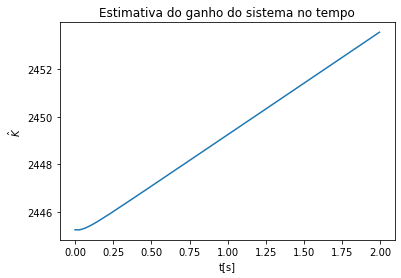

In [20]:
# plt.plot(t, P_hist[1:])
plt.plot(t, x_hist[1:])
plt.title('Estimativa do ganho do sistema no tempo')
plt.ylabel(r'$\hat{K}$')
plt.xlabel('t[s]')
plt.show()

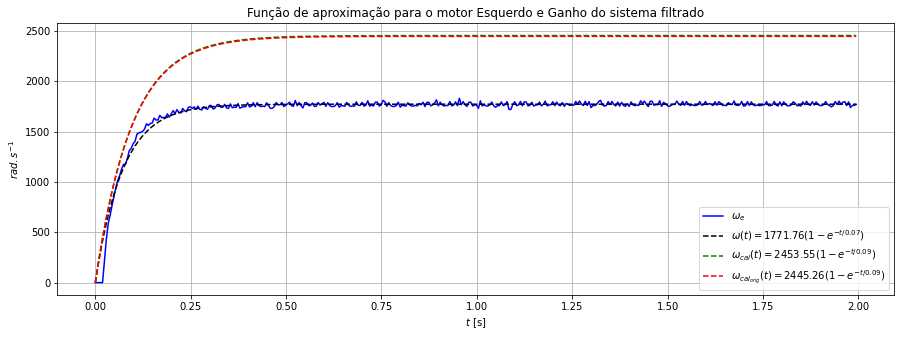

In [21]:
plt.figure(num=1,figsize=(15,5))
plt.title('Função de aproximação para o motor Esquerdo e Ganho do sistema filtrado')
plt.plot(t, we, '-b', label=r'$\omega_e$')
plt.plot(t, func(t,Ke,Tme), '--k', label=r'$\omega(t) = %.2f\left( 1 - e^{-t/%.2f}\right)$'%(Ke,Tme))
plt.plot(t, func(t,x_k,motor_e['TAU'][0]), '--g', label=r'$\omega_{cal}(t) = %.2f\left( 1 - e^{-t/%.2f}\right)$'%(x_k,motor_e['TAU'][0]))
plt.plot(t, func(t,motor_e['K'][0],motor_e['TAU'][0]), '--r', label=r'$\omega_{cal_{orig}}(t) = %.2f\left( 1 - e^{-t/%.2f}\right)$'%(motor_e['K'][0],motor_e['TAU'][0]))

plt.ylabel(r'$rad.s^{-1}$')
plt.xlabel(r'$t$ [s]')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
we[t>=Tme*4].var()

391.036497769718

# Ref. Teórico
## Sistema(Planta):
\begin{equation}
G(s) = \frac{Y(s)}{U(s)} = \frac{K}{T_ms + 1}
\end{equation}

\begin{equation}
y(t) = K(1 - e^{-t/T_m})
\end{equation}

\begin{equation}
\omega(t) = u(t)K\left( 1 - e^{-t/T_m} \right); u(t) \in \left[-1, 1\right]
\end{equation}

## Filtro de Kalman
### Sistema
\begin{equation}
\textbf{x}_k = F_x x_{k-1} + B_k u_k + w_k; w_k \sim N(0, Q_k)
\end{equation}
### Medição
\begin{equation}
z_k = H_k x_k + v_k; v_k \sim N(0, R_k)
\end{equation}

### Predição
$\check{x}_k = F_k \hat{x}_{k-1} + B_k u_k$

$\check{P}_k = F_k \hat{P}_{k-1} F^T_k + Q_k$ 
### Atualização
$K_k = \check{P}_k H^T \left( H_k \check{P}_k H^T_k + R_k\right)^{-1}$

$\hat{x}_k = \check{x}_k + K_k\left( z_k - H_k \check{x}_k \right)$

$\hat{P}_k = \left(I - KH_k \right)\check{P}_k$

## Filtro de Kalman para a nossa planta
\begin{cases}
\textbf{x}_k = \left[ \omega_k \right]\\
z_k = x_k = \omega_k\\
F_k = 1\\
H_k = 1
\end{cases}
### Medição
\begin{align*}
z_k = \omega_z = \frac{N}{\Delta t}.k
\end{align*}

$N$: Números de pulsos;

$k$: Constante para converter de quantidade de pulsos para $rad/s$.
### Predição
\begin{align*}
\check{x}_k &= \hat{x}_{k-1} + (u_k - \hat{x}_{k-1}) \left( 1 - e^{-\frac{\Delta t}{T_m}} \right)\\
\check{x}_k &= \hat{x}_{k-1} +  u^{'}_k \left( 1 - e^{-\frac{\Delta t}{T_m}} \right)\\
\check{P}_k &= \hat{P}_{k-1} + Q_k
\end{align*}

**Obs.:** $\Delta t = t_f - t_0$. $\Delta t$ é relativo ao sinal de entrada $u_k$, sendo $t_0$ o instante que o sinal é aplicado e $t_f$ o instante atual $k$.
### Atualização
\begin{align*}
K_k &= \check{P}_k \left( \check{P}_k + R_k \right)^{-1} = \frac{\check{P}_k}{\check{P}_k + R_k}\\
\hat{x}_k &= \check{x}_k + K_k \left( z_k - \check{x}_k \right)\\
\hat{P}_k &= \left( 1 - K_k \right) \check{P}_k
\end{align*}

In [23]:
we[t >= Tme*5].var()

372.7046210337876

## Teste offline: Filtro de Kalman

In [24]:
# inicialização
p0 = 60.0
r = we[t >= Tme*5].var() #incerteza da medição
q = 0.0  #bias da incerteza (procurar uma definição mais adequada)
#############################################################
w_mean  = np.zeros_like(t)    #omega predito
w_check = np.zeros_like(t)    #omega predito
w_hat   = np.zeros_like(t)    #melhor estimativa de oemga (omega filtrado)
p_check = np.zeros_like(t)    #incerteza de omega
p_hat   = np.zeros_like(t)
K = np.zeros_like(t)          #ganho do filtro

p_check[0] = p_hat[0] = p0
##############################################################
#input
Tm= motor_e['TAU'][0]
Kgain= motor_e['K'][0]
u = 1.0*Kgain

for i in range(1, len(t)):
    # medição
    wz = we[i]
    w_mean[i] = (w_mean[i-1] + wz)/2.0

    # predição
    w_check[i] = w_hat[i-1] + (u - w_hat[i-1])*(1.0 - np.exp(-(t[i]- t[i-1])/Tm))
    p_check[i] = p_hat[i-1] + q

    # atualização
    K[i] = p_check[i]/(p_check[i]+r)
    w_hat[i] = w_check[i] + K[i]*(wz - w_check[i])
    p_hat[i] = (1 - K[i])*p_check[i]

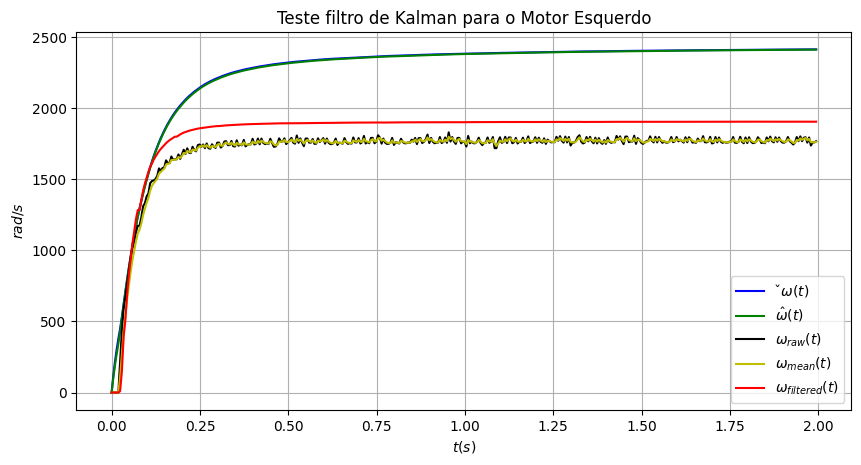

In [25]:
plt.figure(figsize=(10, 5), dpi=100)

plt.plot(t, w_check, '-b', label=r'$\check{\omega}(t)$')

plt.plot(t, w_hat, '-g', label=r'$\hat{\omega}(t)$')

plt.plot(t, we, '-k', label=r'$\omega_{raw}(t)$')

plt.plot(t, w_mean, '-y', label=r'$\omega_{mean}(t)$')

plt.plot(t, motor_e['OMEGA_FILTERED'], '-r', label=r'$\omega_{filtered}(t)$')

plt.title('Teste filtro de Kalman para o Motor Esquerdo')
plt.ylabel(r'$rad/s$');
plt.xlabel(r'$t(s)$');
plt.legend();
plt.grid(True)
plt.show();

In [26]:
# inicialização
p0 = 60.0
r = wd[t >= Tme*5].var() #incerteza da medição
q = 0.0  #bias da incerteza (procurar uma definição mais adequada)
#############################################################
w_mean  = np.zeros_like(t)    #omega predito
w_check = np.zeros_like(t)    #omega predito
w_hat   = np.zeros_like(t)    #melhor estimativa de oemga (omega filtrado)
p_check = np.zeros_like(t)    #incerteza de omega
p_hat   = np.zeros_like(t)
K = np.zeros_like(t)          #ganho do filtro

p_check[0] = p_hat[0] = p0
##############################################################
#input
Tm= motor_d['TAU'][0]
Kgain= motor_d['K'][0]
u = 1.0*Kgain

for i in range(1, len(t)):
    # medição
    wz = we[i]
    w_mean[i] = (w_mean[i-1] + wz)/2.0

    # predição
    w_check[i] = w_hat[i-1] + (u - w_hat[i-1])*(1.0 - np.exp(-(t[i]- t[i-1])/Tm))
    p_check[i] = p_hat[i-1] + q

    # atualização
    K[i] = p_check[i]/(p_check[i]+r)
    w_hat[i] = w_check[i] + K[i]*(wz - w_check[i])
    p_hat[i] = (1 - K[i])*p_check[i]

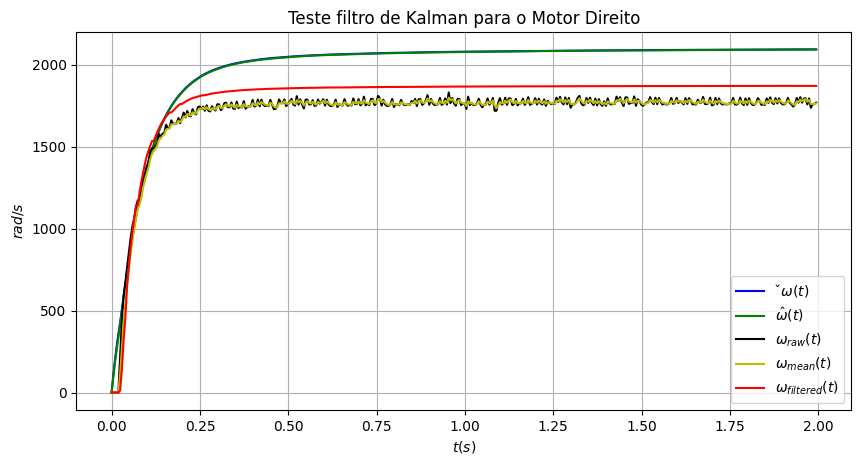

In [27]:
plt.figure(figsize=(10, 5), dpi=100)

plt.plot(t, w_check, '-b', label=r'$\check{\omega}(t)$')

plt.plot(t, w_hat, '-g', label=r'$\hat{\omega}(t)$')

plt.plot(t, we, '-k', label=r'$\omega_{raw}(t)$')

plt.plot(t, w_mean, '-y', label=r'$\omega_{mean}(t)$')

plt.plot(t, motor_d['OMEGA_FILTERED'], '-r', label=r'$\omega_{filtered}(t)$')

plt.title('Teste filtro de Kalman para o Motor Direito')
plt.ylabel(r'$rad/s$');
plt.xlabel(r'$t(s)$');
plt.legend();
plt.grid(True)
plt.show();

In [28]:
# motor_e[:40]

In [29]:
# plt.figure(figsize=(20, 10), dpi=100)

# plt.plot(t, motor_e.OMEGA_FILTERED, '-b', label=r'$\check{\omega}(t)$')

# # plt.plot(t, w_hat, '-g', label=r'$\hat{\omega}(t)$')

# # plt.plot(t, we, '-k', label=r'$\omega_{raw}(t)$')

# # plt.plot(t, w_mean, '-r', label=r'$\omega_{mean}(t)$')

# plt.ylabel(r'$rad/s$');
# plt.xlabel(r'$t(s)$');
# plt.legend();
# plt.grid(True)
# plt.show();

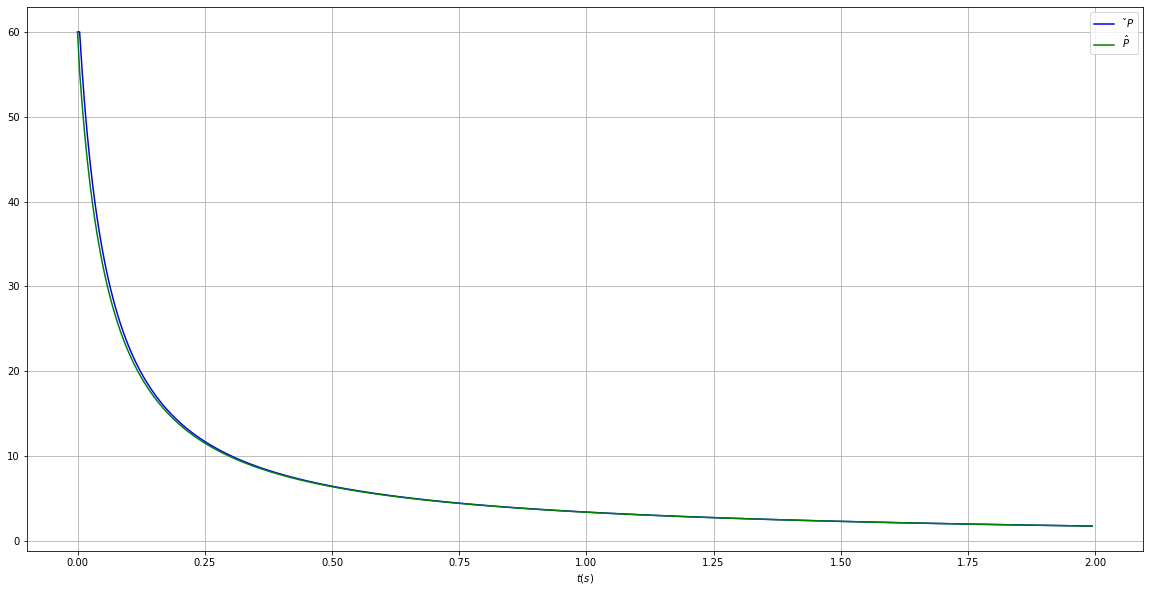

In [30]:
plt.figure(figsize=(20, 10))
# plt.plot(t, K, '-k', label=r'$K_{gain}$')
plt.plot(t, p_check, '-b', label=r'$\check{P}$')
plt.plot(t, p_hat, '-g', label=r'$\hat{P}$')
plt.xlabel(r'$t(s)$');
plt.legend();
plt.grid(True)
plt.show();

In [31]:
p_hat[-1]

1.7430470114544139

In [32]:
w_hat[t >= Tm*6].var()

100.55099252809494

## Controlador

In [33]:
motor_d_c = pd.read_csv('../etc/control_teste_motor_direito_frente.csv')
motor_e_c = pd.read_csv('../etc/control_teste_motor_esquerdo_frente.csv')
# motor_d_c = pd.read_csv('../etc/teste_motor_direito_frente.csv')
# motor_e_c = pd.read_csv('../etc/teste_motor_esquerdo_frente.csv')

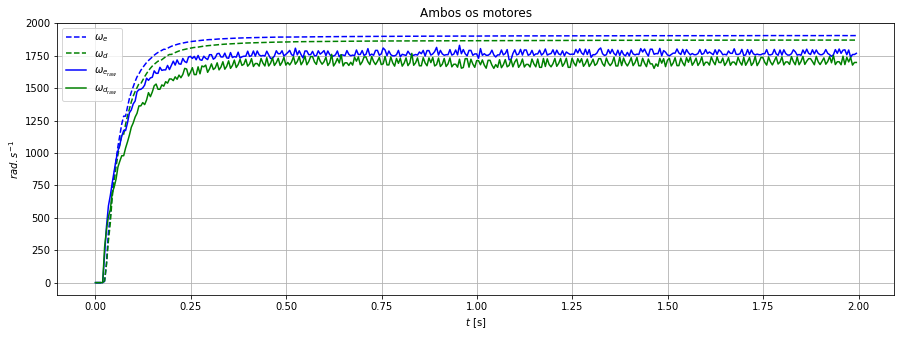

In [35]:
t_c = motor_e_c['TIME']
we_c= motor_e_c['OMEGA_FILTERED']
wd_c= motor_d_c['OMEGA_FILTERED']
# we_c= motor_e_c['OMEGA_RAW']
# wd_c= motor_d_c['OMEGA_RAW']


plt.figure(figsize=(15,5))
plt.title('Ambos os motores')
plt.plot(t_c, we_c, '--b', label=r'$\omega_e$')
plt.plot(t_c, wd_c, '--g', label=r'$\omega_d$')
plt.plot(t_c, motor_e_c['OMEGA_RAW'], '-b', label=r'$\omega_{e_{raw}}$')
plt.plot(t_c, motor_d_c['OMEGA_RAW'], '-g', label=r'$\omega_{d_{raw}}$')

plt.ylabel(r'$rad.s^{-1}$')
plt.xlabel(r'$t$ [s]')
plt.grid(True)
plt.legend()
plt.show()